In [1]:
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import rasterio


In [174]:

# Step 1: Load the GeoDataFrame with polygons and calculate the area of each polygon
votes_gdf = gpd.read_file('fl_2016/fl_2016.shp')

votes_gdf['blue'] = votes_gdf['G16PREDCLI'] + votes_gdf['G16USSDMUR'] # calculate votes for blue per precinct
votes_gdf['red'] = votes_gdf['G16PRERTRU'] + votes_gdf['G16USSRRUB'] # calculate votes for red per precinct

# Step 2: Reproject to a projected CRS
# Choose an appropriate projected CRS. EPSG:3857 (Pseudo-Mercator) or a UTM zone may be suitable.
votes_gdf_projected = votes_gdf.to_crs(epsg=3857)  # You can change EPSG code to a suitable one for your area

# Step 3: Calculate the area using the projected GeoDataFrame
votes_gdf_projected['area'] = votes_gdf_projected.geometry.area

# Define the attribute columns to be rasterized
selected_columns = ['blue', 'red']

# Step 2: Define the bounds and raster properties
minx, miny, maxx, maxy = votes_gdf_projected.total_bounds
pixel_size = 6000
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Set up the transform for the raster
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# Step 3: Rasterize each attribute column separately into bands with fractional values
raster_bands = []

for col in selected_columns:
    # Generate shapes for rasterization, now including fractional values
    shapes = (
        (geom, value / area) for geom, value, area in zip(votes_gdf_projected.geometry, votes_gdf_projected[col], votes_gdf_projected['area'])
    )
    
    raster_band = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='float32'  # Using float to handle fractional values
    )
    raster_bands.append(raster_band)

In [175]:
votes_gdf_projected.head()

,COUNTY,PRECINCT,PCT_STD,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16PREGSTE,G16PREODEL,G16PREOWRI,...,G16USSLSTA,G16USSNKHO,G16USSNNAT,G16USSNMAC,G16USSNDAL,G16USSOWRI,geometry,blue,red,area
0,PUT,06,PUT0006,209,101,5,0,4,0,2,...,11,3,6,2,2,0,"POLYGON Z ((-9080397.337 3439279.763 0, -90803...",199,395,1.178094e+07
1,PUT,01,PUT0001,330,304,13,1,3,0,7,...,11,5,6,2,0,0,"POLYGON Z ((-9074151.316 3433297.543 0, -90740...",577,682,8.110286e+06
2,PUT,21,PUT0021,335,229,20,2,4,2,4,...,9,5,4,3,2,1,"POLYGON Z ((-9113729.643 3455898.29 0, -911372...",431,698,2.206357e+07
3,PUT,20,PUT0020,1083,601,30,1,10,3,8,...,44,15,5,7,2,3,"POLYGON Z ((-9121634.831 3441018.245 0, -91216...",1208,2114,1.842854e+08
4,PUT,18,PUT0018,1111,537,46,3,15,1,6,...,51,3,13,5,5,1,"POLYGON Z ((-9122126.086 3459877.047 0, -91221...",1056,2205,1.098959e+08


In [204]:
votes_gdf_projected["blue"].sum() + votes_gdf_projected["red"].sum()

np.int64(18080140)

In [176]:
raster_bands[0].shape

(138, 142)

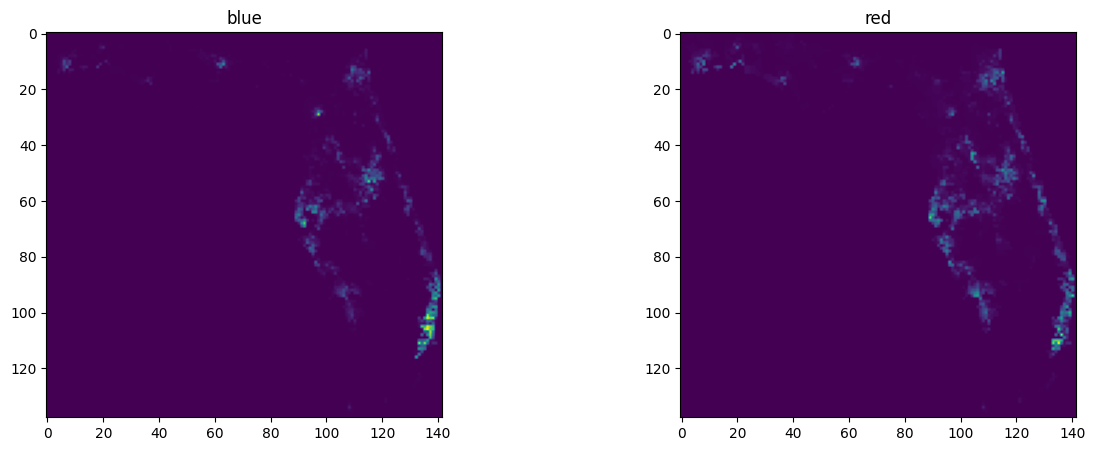

In [177]:
# Visualize one of the raster bands for verification (optional)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(selected_columns), figsize=(15, 5))
for i, band in enumerate(raster_bands):
    axs[i].imshow(band, cmap='viridis')
    axs[i].set_title(f'{selected_columns[i]}')
plt.show()


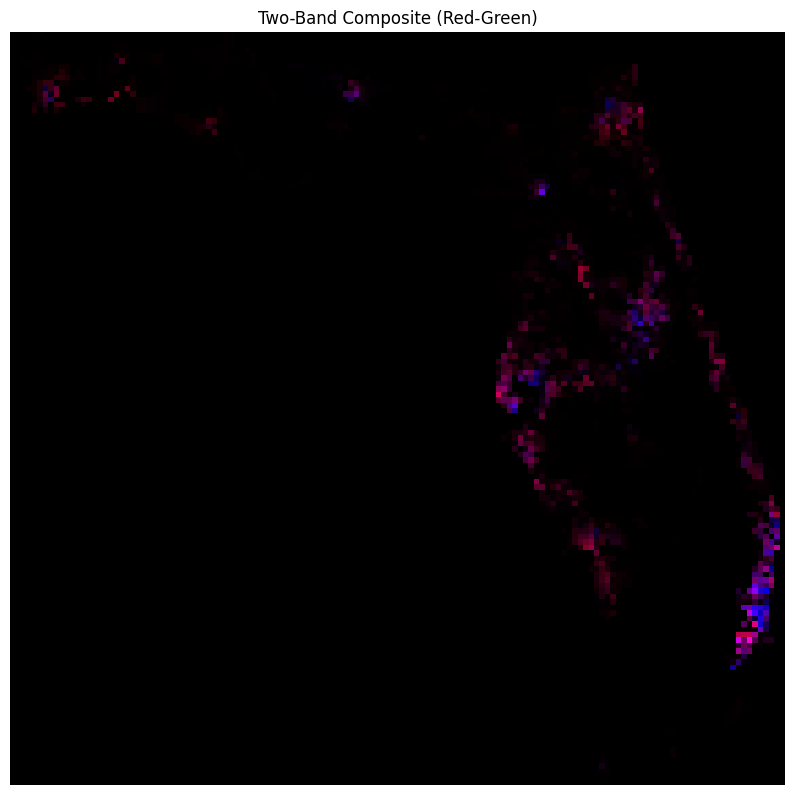

In [178]:
# Get the two bands
blue_band = raster_bands[0]
red_band = raster_bands[1]

# Normalize bands to [0, 1] for visualization
def normalize(array):
    return (array - array.min()) / (array.max() - array.min())

blue_norm = normalize(blue_band)
red_norm = normalize(red_band)
green_norm = np.zeros_like(red_norm)  # Set green channel to zero

# Stack bands to create an RGB image
rgb = np.dstack((red_norm, green_norm, blue_norm))

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title('Two-Band Composite (Red-Green)')
plt.axis('off')
plt.show()

In [182]:
import random

# Step 1: Create a mask for valid pixels (non-zero values in either band)
mask = (blue_band > 0) | (red_band > 0)  # Create a mask where either band has non-zero value

# Step 2: Find row and column indices of valid pixels
valid_pixels = np.argwhere(mask)

# Check if there are any valid pixels to sample from
if len(valid_pixels) == 0:
    print("No valid pixels found inside the state boundaries.")
else:
    # Step 3: Randomly choose one valid pixel from the list
    random_index = random.randint(0, len(valid_pixels) - 1)
    row, col = valid_pixels[random_index]

    # Step 4: Extract values from both bands at the selected pixel
    blue_value = blue_band[row, col]
    red_value = red_band[row, col]

    # Display the values for the randomly selected pixel
    print(f"Randomly selected pixel at (row {row}, col {col}):")
    print(f"  Value in Blue Band: {blue_value}")
    print(f"  Value in Red Band: {red_value}")

Randomly selected pixel at (row 46, col 102):
  Value in Blue Band: 3.102044274783111e-06
  Value in Red Band: 8.62385695654666e-06


In [183]:
np.sum([np.sum(band) for band in raster_bands])

np.float32(0.50507987)

Random sample from boundaries

In [25]:
# create a GeoDataFrame with the boundaries of congressional districts
districts_gdf = gpd.read_file('fl_2016_congressional_districts/fl_2016_congressional_districts.shp')

# project into same scale
districts_gdf_projected = districts_gdf.to_crs(epsg=3857)

# assign id to each district
districts_gdf_projected["poly_id"] = np.arange(len(districts_gdf_projected))

# get polygon boundaries
boundary_gdf = districts_gdf_projected.copy()
boundary_gdf['geometry'] = boundary_gdf.geometry.boundary

In [27]:

# Rasterize the boundaries
boundary_shapes = ((geom, 1) for geom in boundary_gdf.geometry)
boundary_mask = rasterize(
    shapes=boundary_shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# Also rasterize polygon IDs
poly_id_shapes = ((geom, pid) for geom, pid in zip(districts_gdf_projected.geometry, districts_gdf_projected['poly_id']))
poly_id_raster = rasterize(
    shapes=poly_id_shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='int32'
)

# mask pixels that have non-zero value and in a border
mask = ((blue_band > 0) | (red_band > 0)) & (boundary_mask > 0)

# get all candidate pixels
candidate_pixels = np.argwhere(mask)

# get pixels that are in the border of two districts
def get_neighbors(r, c, arr):
    """Get the values of the 8-connected neighbors and the pixel itself."""
    rows = [r-1, r-1, r-1, r, r, r+1, r+1, r+1]
    cols = [c-1, c, c+1, c-1, c+1, c-1, c, c+1]
    vals = []
    for rr, cc in zip(rows, cols):
        if 0 <= rr < arr.shape[0] and 0 <= cc < arr.shape[1]:
            vals.append(arr[rr, cc])
    return vals

# Filter candidate pixels to those between exactly two distinct polygons
valid_pixels = []
for (row, col) in candidate_pixels:
    # Get polygon IDs of neighbors
    neighbor_ids = get_neighbors(row, col, poly_id_raster)
    # Include the pixel itself to consider its own polygon ID
    center_id = poly_id_raster[row, col]
    all_ids = neighbor_ids + [center_id]
    
    # Count distinct non-zero IDs
    distinct_ids = set(all_ids) - {0}
    if len(distinct_ids) == 2:
        valid_pixels.append((row, col))

Randomly selected boundary pixel at (row 30, col 106):
  Value in Blue Band: 3.0131386665743776e-06
  Value in Red Band: 1.0818602277140599e-05


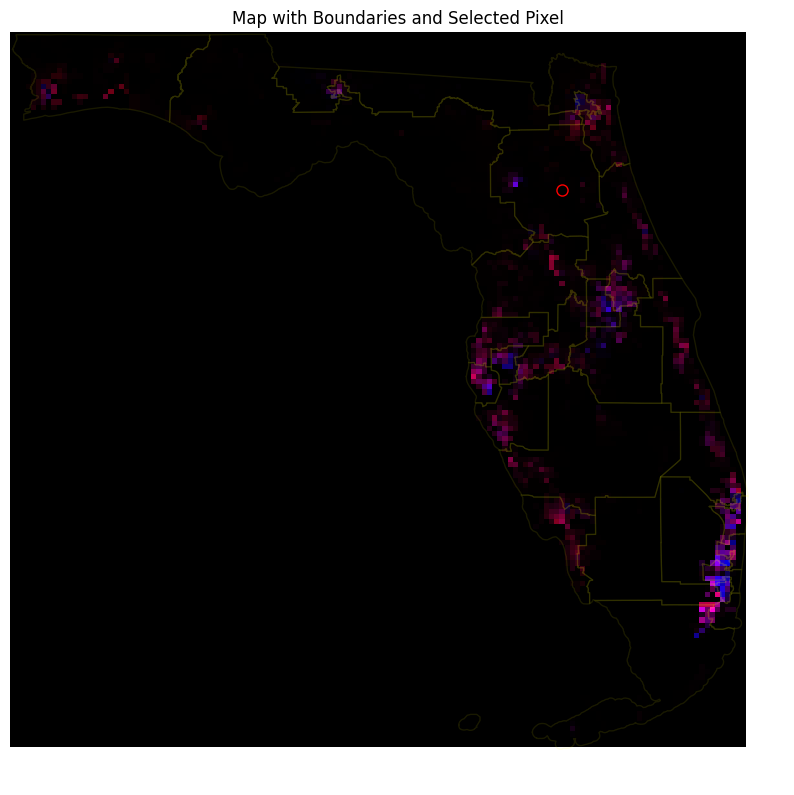

In [189]:
# random sample a pixel and display 
if len(valid_pixels) == 0:
    print("No valid boundary pixels found.")
else:
    random_index = random.randint(0, len(valid_pixels) - 1)
    row, col = valid_pixels[random_index]

    blue_value = blue_band[row, col]
    red_value = red_band[row, col]

    print(f"Randomly selected boundary pixel at (row {row}, col {col}):")
    print(f"  Value in Blue Band: {blue_value}")
    print(f"  Value in Red Band: {red_value}")

    # Plot the RGB image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(rgb, origin='upper')

    # Mark the selected pixel
    ax.plot(col, row, 'ro', markersize=8, markerfacecolor='none', markeredgecolor='red')

    # Convert line geometries from projected coords to pixel coords and plot them
    inv_transform = ~transform  # Inverse transform to go from map coords to pixel coords
    for geom in boundary_gdf.geometry:
        # Each geometry is a LineString or MultiLineString
        if geom is None:
            continue
        
        if geom.geom_type == 'MultiLineString':
            lines = geom.geoms
        else:
            lines = [geom]

        for line in lines:
            x_coords, y_coords = line.xy
            # Convert to pixel coordinates
            pixel_coords = [inv_transform * (x, y) for x, y in zip(x_coords, y_coords)]
            # pixel_coords is now a list of (col, row) tuples
            cols, rows = zip(*pixel_coords)
            ax.plot(cols, rows, color='yellow', linewidth=1, alpha=0.1)

    ax.set_title('Map with Boundaries and Selected Pixel')
    ax.axis('off')
    plt.show()

### Generate random districts

We have to make sure each district has approximately the same population.

For our purposes, let's just assume the total population of Florida is the total number of votes (since we couldn't find a total population per voting district dataset).

In [ ]:
total_pop = votes_gdf["blue"].sum() + votes_gdf["red"].sum()
num_districts = 27 # in 2016
target_pop = total_pop / num_districts

print(f"Total population: {total_pop}")
print(f"Target population per district: {target_pop:.2f}")

Total population: 18080140
Target population per district: 669634.81


In [120]:
# total population per pixel
population = raster_bands[0] + raster_bands[1]

height, width = population.shape

In [134]:
raster_bands[1].max()

np.float32(0.002713526)

In [123]:
sum(sum(row) for row in population)

np.float32(2.0332344)

## Combined

Total population: 0.50507987
Target population per district: 0.018706663
Final district populations: [0.01827553 0.0190841  0.01827364 0.01825644 0.01913242 0.01860808
 0.01840221 0.01968699 0.01884185 0.01850573 0.01829096 0.01862388
 0.01880304 0.02003797 0.01825602 0.01846022 0.01843788 0.01851768
 0.01828815 0.0182555  0.01887894 0.02029618 0.01826186 0.01884506
 0.01905992 0.01827802 0.01842154]
Differences from target: [-4.31134061e-04  3.77437590e-04 -4.33018541e-04 -4.50221184e-04
  4.25758779e-04 -9.85824049e-05 -3.04450355e-04  9.80331481e-04
  1.35190447e-04 -2.00934085e-04 -4.15704514e-04 -8.27842983e-05
  9.63776896e-05  1.33130266e-03 -4.50641063e-04 -2.46439429e-04
 -2.68780636e-04 -1.88985969e-04 -4.18508858e-04 -4.51158127e-04
  1.72276111e-04  1.58951732e-03 -4.44799918e-04  1.38401028e-04
  3.53252489e-04 -4.28639342e-04 -2.85121325e-04]


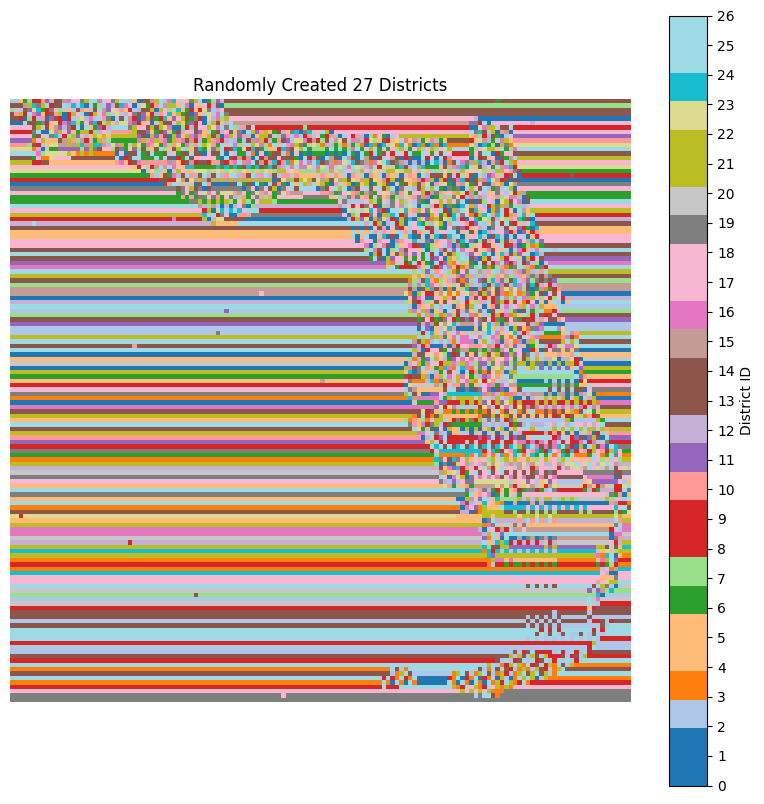

In [202]:
# --------------------------------------
# Part 1: Load and rasterize from your shapefiles (Provided code)
# --------------------------------------

# Load precinct data
votes_gdf = gpd.read_file('fl_2016/fl_2016.shp')

votes_gdf['blue'] = votes_gdf['G16PREDCLI'] + votes_gdf['G16USSDMUR']  # Blue votes
votes_gdf['red'] = votes_gdf['G16PRERTRU'] + votes_gdf['G16USSRRUB']   # Red votes

# Reproject to a projected CRS for area calculation
votes_gdf_projected = votes_gdf.to_crs(epsg=3857)
votes_gdf_projected['area'] = votes_gdf_projected.geometry.area

# Define attributes to rasterize
selected_columns = ['blue', 'red']

# Define raster properties
minx, miny, maxx, maxy = votes_gdf_projected.total_bounds
pixel_size = 6000
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# Rasterize attributes as fractional values
raster_bands = []
for col in selected_columns:
    shapes = (
        (geom, value / area) 
        for geom, value, area in zip(votes_gdf_projected.geometry,
                                     votes_gdf_projected[col],
                                     votes_gdf_projected['area'])
    )
    raster_band = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='float32'
    )
    raster_bands.append(raster_band)

blue_band = raster_bands[0]
red_band = raster_bands[1]

# Combine bands to form a population array (e.g., total votes)
population = blue_band + red_band

# --------------------------------------
# Part 2: Create random 27 districts
# --------------------------------------

num_districts = 27
total_pop = population.sum()
target_pop = total_pop / num_districts
tolerance = 50000  # adjust as needed

print("Total population:", total_pop)
print("Target population per district:", target_pop)

# We need to pick 27 seed pixels randomly.
indices = np.arange(height * width)
np.random.shuffle(indices)
seed_pixels = indices[:num_districts]
seed_coords = [(idx // width, idx % width) for idx in seed_pixels]

district_map = np.full((height, width), -1, dtype=int)  # -1 means unassigned

# Directions for neighbors (4-directional)
directions = [(1,0), (-1,0), (0,1), (0,-1)]

assigned_count = 0
district_pops = np.zeros(num_districts, dtype=np.float64)

# BFS for each district starting from a seed pixel
for d_id, (sr, sc) in enumerate(seed_coords):
    if district_map[sr, sc] != -1:
        # If by some chance the seed is already taken, skip
        continue
    
    # Initialize the queue for BFS
    queue = deque()
    queue.append((sr, sc))
    district_map[sr, sc] = d_id
    district_pops[d_id] += population[sr, sc]
    assigned_count += 1
    
    # Grow the district
    while queue:
        # Check if the population is within target ± tolerance
        if (district_pops[d_id] >= target_pop - tolerance and 
            district_pops[d_id] <= target_pop + tolerance):
            # Within desired range, stop expanding this district
            break
        
        r, c = queue.popleft()
        # Try adding neighbors
        for dr, dc in directions:
            nr, nc = r+dr, c+dc
            if 0 <= nr < height and 0 <= nc < width:
                if district_map[nr, nc] == -1:
                    district_map[nr, nc] = d_id
                    district_pops[d_id] += population[nr, nc]
                    assigned_count += 1
                    queue.append((nr, nc))
                    
                    # If we overshoot a lot, break early
                    if district_pops[d_id] > target_pop + 2*tolerance:
                        queue.clear()
                        break

# Assign unassigned pixels to the district with the least population 
unassigned_pixels = np.argwhere(district_map == -1)
for (ur, uc) in unassigned_pixels:
    smallest_dist_id = np.argmin(district_pops)
    district_map[ur, uc] = smallest_dist_id
    district_pops[smallest_dist_id] += population[ur, uc]

print("Final district populations:", district_pops)
print("Differences from target:", district_pops - target_pop)

# --------------------------------------
# Visualization (optional)
# --------------------------------------

# Normalize bands to [0, 1] for visualization of original data
def normalize(array):
    return (array - array.min()) / (array.max() - array.min() + 1e-9)

blue_norm = normalize(blue_band)
red_norm = normalize(red_band)
green_norm = np.zeros_like(red_norm)  # Just set green to zero for a red-blue mix

rgb = np.dstack((red_norm, green_norm, blue_norm))

# Plot the resulting districts
cmap = plt.get_cmap('tab20', num_districts)
plt.figure(figsize=(10, 10))
im = plt.imshow(district_map, cmap=cmap, interpolation='nearest', origin='upper')
plt.colorbar(im, ticks=range(num_districts), label='District ID')
plt.title('Randomly Created 27 Districts')
plt.axis('off')
plt.show()
